<a href="https://colab.research.google.com/github/Benteaux/karpathy-tutorials/blob/main/notebooks/makemore2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# makemore 2!

In [ ]:
import torch
import matplotlib.pyplot as plt
names = open("names.txt", "r").read().splitlines()

In [ ]:
len(names)

32033

In [ ]:
alphabet = sorted(list(set('.'.join(names))))
stoi = {s:i for i, s in enumerate(alphabet)}
itos = {i:s for s, i in stoi.items()}

In [ ]:
X, Y = [], []
block = 3 # size of context window
for name in names:
  context = [0] * block
  for char in name + '.':
    ix = stoi[char]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]


In [ ]:
x = torch.tensor(X)
y = torch.tensor(Y)

In [ ]:
x, y

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [ ]:
block = 3
def build_dataset(data):
  x = []
  y = []
  for name in data:
    context = [0] * block
    for char in name + '.':
      ix = stoi[char]
      x.append(context)
      y.append(ix)
      context = context[1:] + [ix]

  x = torch.tensor(x)
  y = torch.tensor(y)
  print(f'{x.shape}, {y.shape}')
  return x, y

import random
random.seed(1)
random.shuffle(names)
length = len(names)
n1 = int((0.8 * length))
n2 = int((0.9 * length))

xtr, ytr = build_dataset(names[:n1])
xdev, ydev = build_dataset(names[n1:n2])
xte, yte = build_dataset(names[n2:])

torch.Size([182254, 3]), torch.Size([182254])
torch.Size([22914, 3]), torch.Size([22914])
torch.Size([22978, 3]), torch.Size([22978])


In [ ]:

g = torch.Generator().manual_seed(1)
# create a table
em_dim = 50
C = torch.randn((27, em_dim), generator = g) # for each letter we want a row with x embedding values
W1 = torch.randn((em_dim * block, 300), generator = g) # 30 b/c for input context block size of 3, * 10 embedding values, we have 30 inputs when flattened
b1 = torch.randn(300, generator = g)
W2 = torch.randn((300, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = (C, W1, b1, W2, b2)
non_bias_params = (C, W1, W2)

In [ ]:
sum(p.nelement() for p in parameters)

54777

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
xtr.shape, ytr.shape

(torch.Size([182254, 3]), torch.Size([182254]))

In [ ]:
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre

In [ ]:
scale = 0.0001
lri = []
losses = []
stepi = []
for i in range(100000):
  # forward pass
  ix = torch.randint(0, xtr.shape[0], (32,))
  emb = C[xtr[ix]]
  h = torch.tanh(emb.view(-1, em_dim * block) @ W1 + b1)
  logits = h @ W2 + b2
  decay_penalty = 0
  for p in non_bias_params:
    decay_penalty += p.sum()**2
  loss = torch.nn.functional.cross_entropy(logits, ytr[ix]) + scale*decay_penalty
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # optimization
  lr = 0.1 if i < 70000 else 0.01 if i < 90000 else 0.001
  for p in parameters:
    p.data += -lr * p.grad
  #lri.append(lrs[i])
  stepi.append(i)
  losses.append(loss.log10().item())

In [ ]:
loss.item()

2.2036566734313965

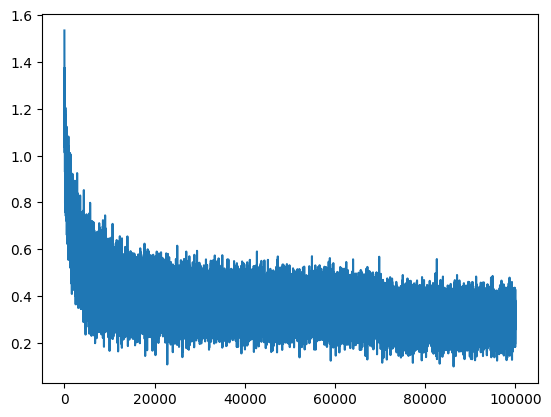

In [ ]:
plt.plot(stepi, losses)

In [ ]:
# loss on train set
emb = C[xtr]
h = torch.tanh(emb.view(-1, block * em_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = torch.nn.functional.cross_entropy(logits, ytr)
loss

tensor(2.0294, grad_fn=<NllLossBackward0>)

In [ ]:
# loss on dev set
emb = C[xdev]
h = torch.tanh(emb.view(-1, block * em_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = torch.nn.functional.cross_entropy(logits, ydev)
loss

tensor(2.1542, grad_fn=<NllLossBackward0>)

In [ ]:
uniform = torch.full((22886,27), -234902384.0)

In [ ]:
loss = torch.nn.functional.cross_entropy(uniform, ydev)
loss

tensor(3.2958)

In [ ]:
# emb dim = 50 -> 2.3458
# + exponential decay -> 2.1494 # randn initialization
# + weight decay -> 2.1594, 1.1542, and similar values

In [ ]:
# optimize by indexing if possible
# model smoothing / regularization can help prevent nan and overfitting
# optimize with minibatches
# overfit a single batch (see minimum possible loss) - helps catch bugs (explosion, instability, vanishing, etc)
# larger models are more capable of overfitting
# test a ton of learning rates (visualization helps find the best one)
# dev split for optimizing hyperparameters (you use it to go back and make edits to the model)
# test set should be looked at sparingly to avoid tweaking and then overfitting to test set
# typically, optimize dev set, run test set once, then use test set's loss as "the loss" when you talk about your model